In [21]:
conda install -c conda-forge xgboost

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.11.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.11.0



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [62]:
# Library to suppress warnings or deprecation notes
import warnings
warnings.filterwarnings("ignore")

# Libraries to help with reading and manipulating data
import numpy as np   
import pandas as pd

# Libraries to help with data visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Libraries to import and tune models, to get different metric scores, and to split data
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor,RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, StackingRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split
import scipy.stats as stats

In [23]:
#Loading dataset
data=pd.read_csv("Cars-dataset.csv")

In [24]:
data.head()

,Age,Gender,Engineer,MBA,Work Exp,Salary,Distance,license,Opt_service
0,28,Male,1,0,5,14.4,5.1,0,0
1,24,Male,1,0,6,10.6,6.1,0,0
2,27,Female,1,0,9,15.5,6.1,0,0
3,25,Male,0,0,1,7.6,6.3,0,0
4,25,Female,0,0,3,9.6,6.7,0,0


In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          418 non-null    int64  
 1   Gender       418 non-null    object 
 2   Engineer     418 non-null    int64  
 3   MBA          418 non-null    int64  
 4   Work Exp     418 non-null    int64  
 5   Salary       418 non-null    float64
 6   Distance     418 non-null    float64
 7   license      418 non-null    int64  
 8   Opt_service  418 non-null    int64  
dtypes: float64(2), int64(6), object(1)
memory usage: 29.5+ KB


In [26]:
data.shape

(418, 9)

In [27]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,418.0,27.334928,4.153272,18.0,25.000,27.0,29.000,43.0
Engineer,418.0,0.748804,0.434221,0.0,0.250,1.0,1.000,1.0
MBA,418.0,0.260766,0.439578,0.0,0.000,0.0,1.000,1.0
Work Exp,418.0,5.873206,4.816110,0.0,3.000,5.0,8.000,24.0
Salary,418.0,15.418421,9.660234,6.5,9.625,13.0,14.900,57.0
Distance,418.0,11.306220,3.722143,3.2,8.600,10.9,13.575,23.4
license,418.0,0.205742,0.404727,0.0,0.000,0.0,0.000,1.0
Opt_service,418.0,0.083732,0.277317,0.0,0.000,0.0,0.000,1.0


In [28]:
data.nunique()

Age             25
Gender           2
Engineer         2
MBA              2
Work Exp        24
Salary         116
Distance       138
license          2
Opt_service      2
dtype: int64

In [29]:
cat_cols=['Gender','Engineer','MBA','license','Opt_service']

for column in cat_cols:
    print(data[column].value_counts())
    print('-'*30)

Male      297
Female    121
Name: Gender, dtype: int64
------------------------------
1    313
0    105
Name: Engineer, dtype: int64
------------------------------
0    309
1    109
Name: MBA, dtype: int64
------------------------------
0    332
1     86
Name: license, dtype: int64
------------------------------
0    383
1     35
Name: Opt_service, dtype: int64
------------------------------


In [30]:
cat_cols=['Gender','Engineer','MBA','license','Opt_service']

for column in cat_cols:
    print(data[column].value_counts(1))
    print('-'*30)

Male      0.710526
Female    0.289474
Name: Gender, dtype: float64
------------------------------
1    0.748804
0    0.251196
Name: Engineer, dtype: float64
------------------------------
0    0.739234
1    0.260766
Name: MBA, dtype: float64
------------------------------
0    0.794258
1    0.205742
Name: license, dtype: float64
------------------------------
0    0.916268
1    0.083732
Name: Opt_service, dtype: float64
------------------------------


In [31]:
df = data.copy()

In [32]:
def histogram_boxplot(data, feature, figsize=(15, 10), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (15,10))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a triangle will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

In [33]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 2, 6))
    else:
        plt.figure(figsize=(n + 2, 6))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n],
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

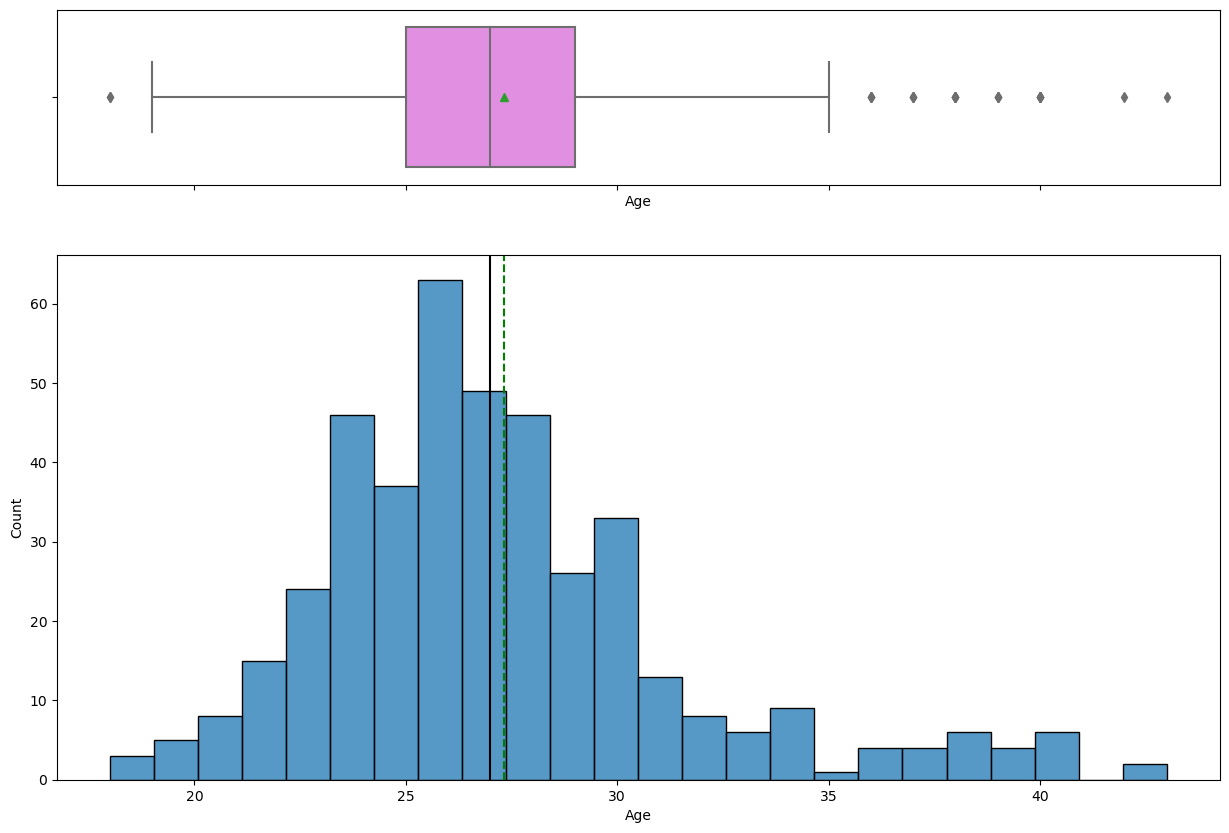

In [34]:
histogram_boxplot(df, "Age")

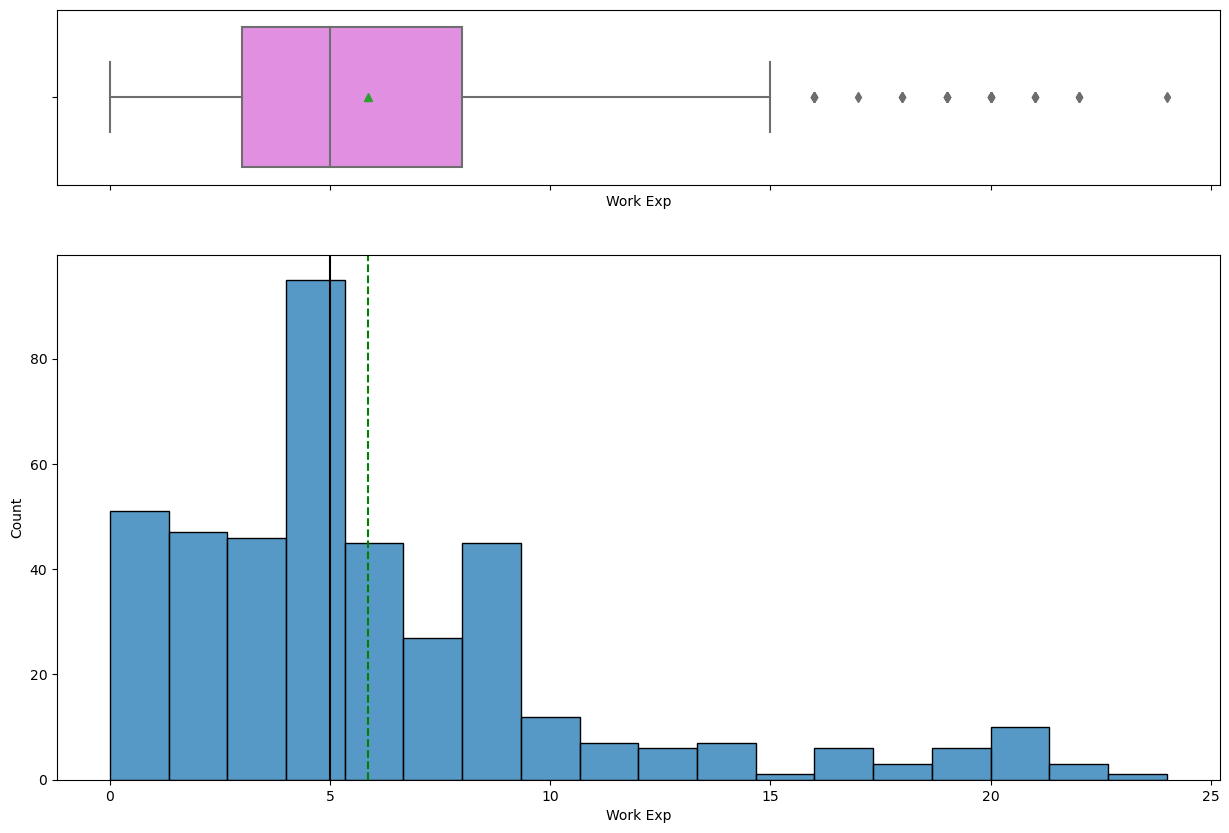

In [35]:
histogram_boxplot(df, "Work Exp")

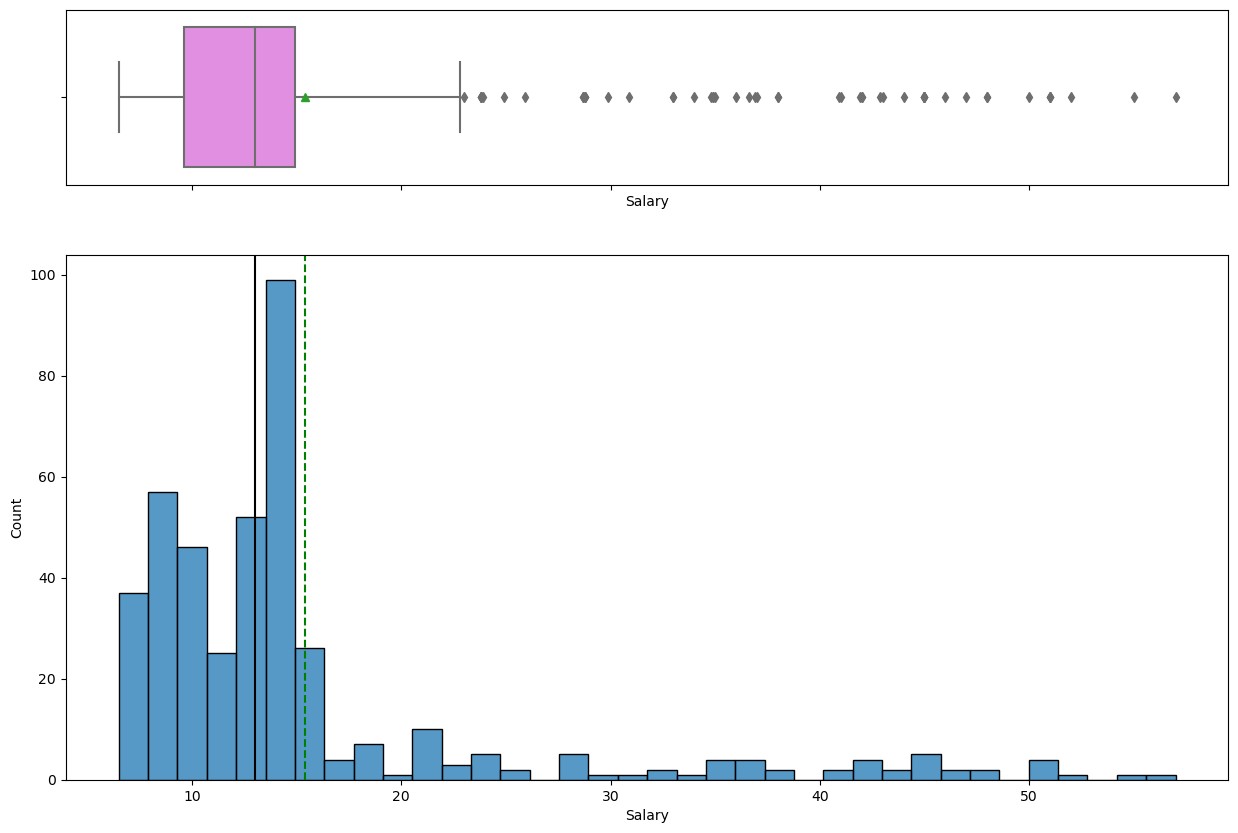

In [36]:
histogram_boxplot(df, "Salary")

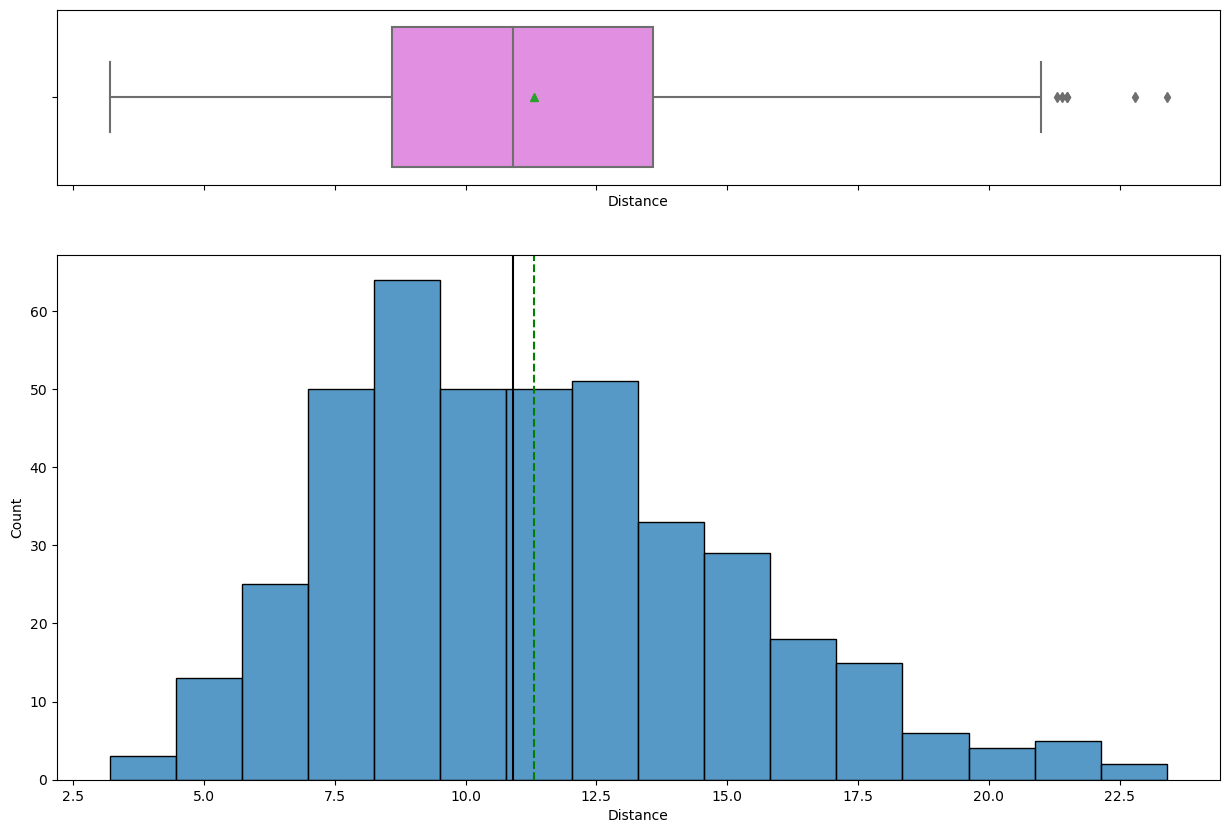

In [37]:
histogram_boxplot(df, "Distance")

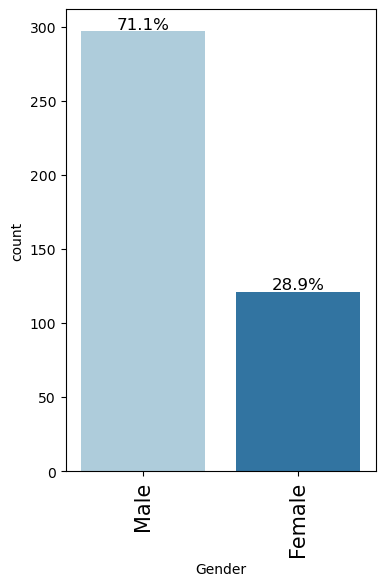

In [38]:
labeled_barplot(df, "Gender",perc=True)

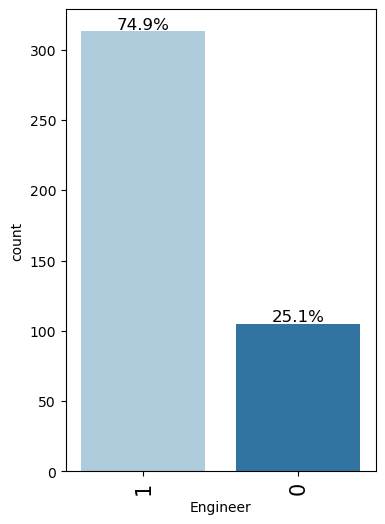

In [39]:
labeled_barplot(df, "Engineer",perc=True)

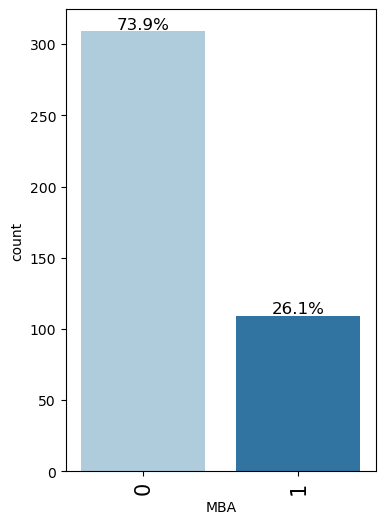

In [40]:
labeled_barplot(df, "MBA",perc=True)

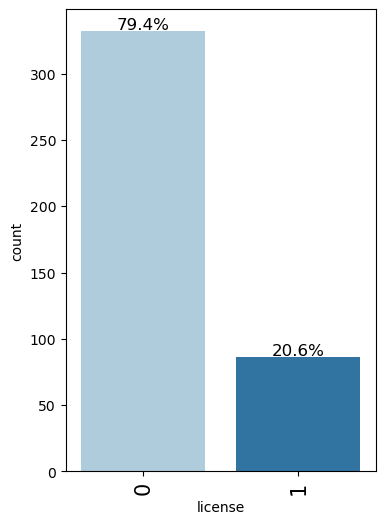

In [42]:
labeled_barplot(df, "license",perc=True)

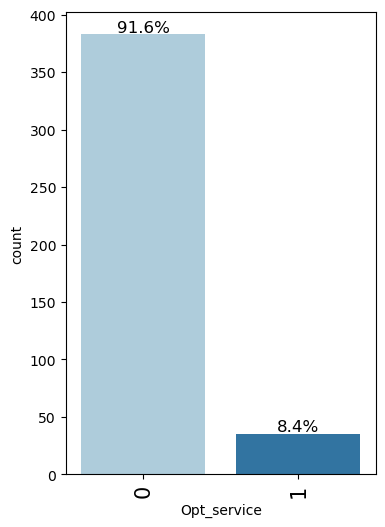

In [44]:
labeled_barplot(df, "Opt_service",perc=True)

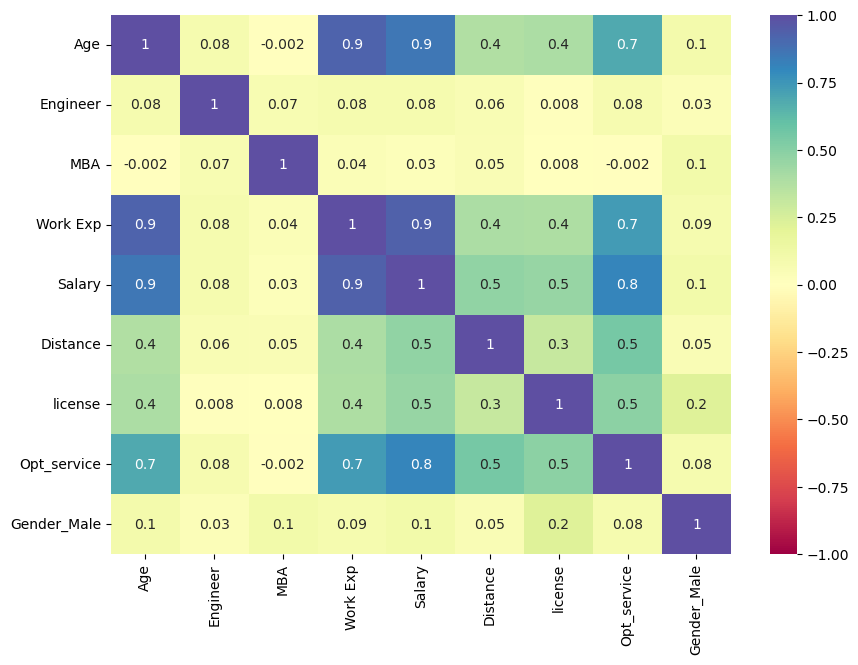

In [92]:
plt.figure(figsize=(10,7))
sns.heatmap(df.corr(),annot=True,vmin=-1,vmax=1,fmt='.1g',cmap="Spectral")
plt.show()

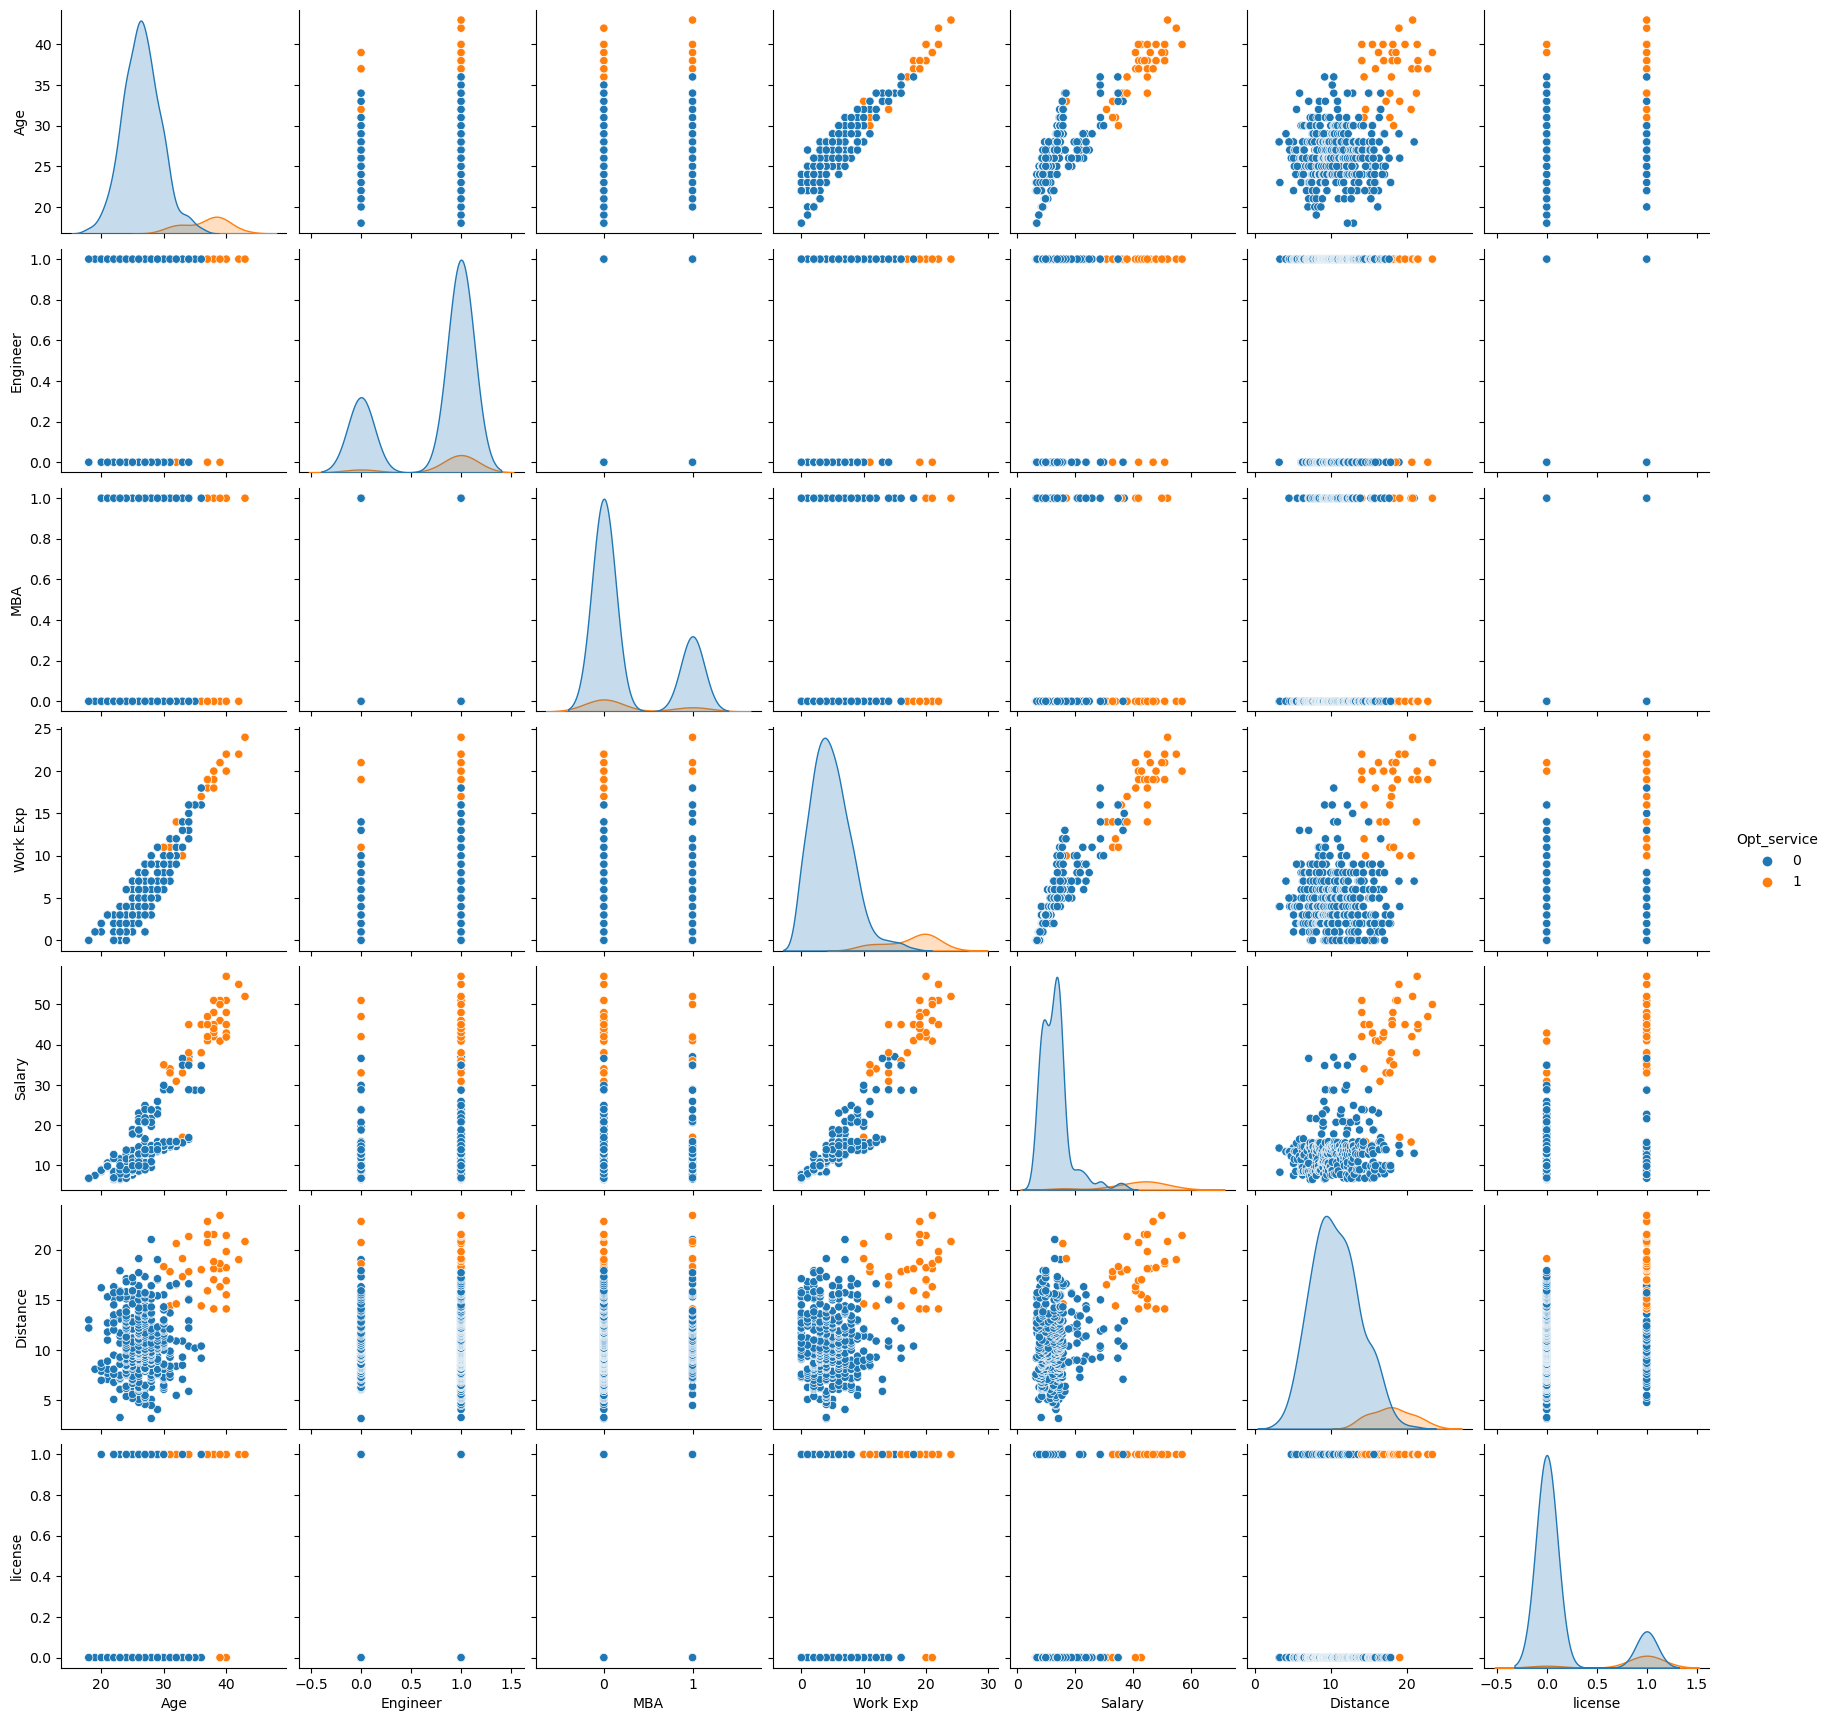

In [49]:
sns.pairplot(df,hue='Opt_service')
plt.show()

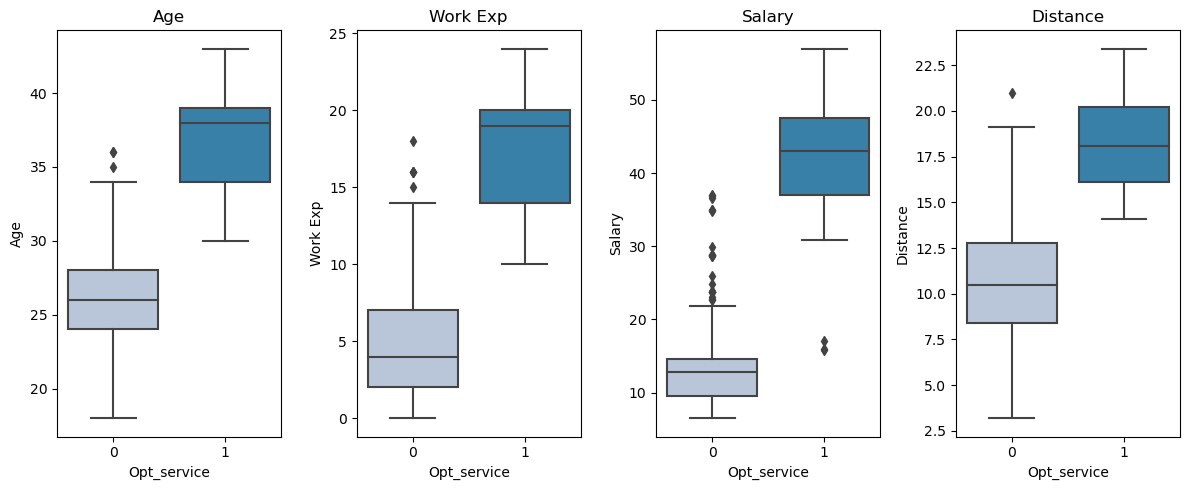

In [51]:
cols = df[['Age', 'Work Exp', 'Salary', 'Distance']].columns.tolist()
plt.figure(figsize=(12,5))

for i, variable in enumerate(cols):
                     plt.subplot(1,4,i+1)
                     sns.boxplot(x=df['Opt_service'],y=df[variable],palette="PuBu")
                     plt.tight_layout()
                     plt.title(variable)
plt.show()

In [53]:
df = pd.get_dummies(df, drop_first=True)

In [54]:
X = df.drop('Opt_service', axis=1)
y = df['Opt_service']

In [55]:
# Splitting data into training and test set:
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.3, random_state=1)
print(X_train.shape, X_test.shape)

(292, 8) (126, 8)


In [56]:
y.value_counts(1)

0    0.916268
1    0.083732
Name: Opt_service, dtype: float64

In [89]:
y_test.value_counts(1)

0    0.912698
1    0.087302
Name: Opt_service, dtype: float64

In [59]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1,
        },
        index=[0],
    )

    return df_perf

In [60]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

   Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


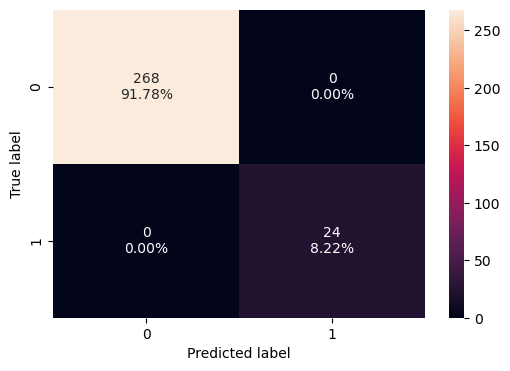

In [66]:
#Fitting the model
bagging_classifier = BaggingClassifier(random_state=1)
bagging_classifier.fit(X_train,y_train)

#Calculating different metrics
bagging_classifier_model_train_perf=model_performance_classification_sklearn(bagging_classifier,X_train,y_train)
print(bagging_classifier_model_train_perf)


#Creating confusion matrix
confusion_matrix_sklearn(bagging_classifier,X_train,y_train)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


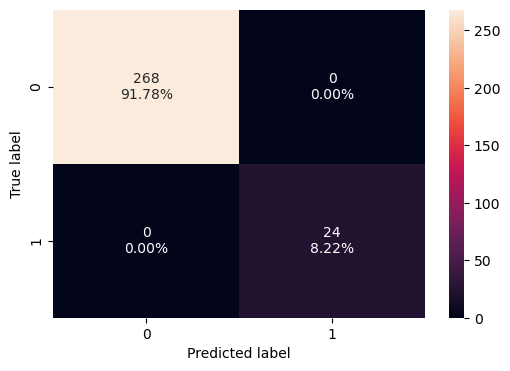

In [67]:
#Fitting the model
rf_estimator = RandomForestClassifier(random_state=1)
rf_estimator.fit(X_train,y_train)

#Calculating different metrics
rf_estimator_model_train_perf=model_performance_classification_sklearn(rf_estimator,X_train,y_train)
print("Training performance:\n",rf_estimator_model_train_perf)

#Creating confusion matrix
confusion_matrix_sklearn(rf_estimator,X_train,y_train)

   Accuracy    Recall  Precision       F1
0  0.989726  0.916667   0.956522  0.93617


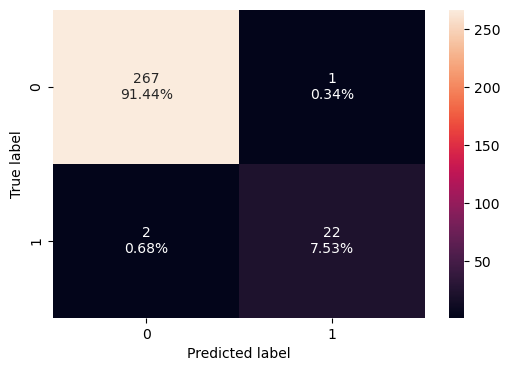

In [70]:
#Fitting the model
logistic_regressor = LogisticRegression()
bagging_classifier_logistic = BaggingClassifier(logistic_regressor, random_state=1)
bagging_classifier_logistic.fit(X_train,y_train)

#Calculating different metrics
bagging_classifier_logistic_train_perf=model_performance_classification_sklearn(bagging_classifier_logistic,X_train,y_train)
print(bagging_classifier_logistic_train_perf)


#Creating confusion matrix
confusion_matrix_sklearn(bagging_classifier_logistic,X_train,y_train)

   Accuracy  Recall  Precision    F1
0  0.972603   0.875   0.807692  0.84


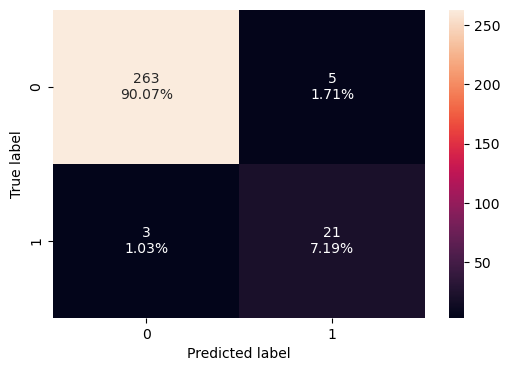

In [71]:
#Fitting the model
decision_tree_1 = DecisionTreeClassifier(max_depth=1)
bagging_classifier_decision_tree_1 = BaggingClassifier(decision_tree_1, random_state=1)
bagging_classifier_decision_tree_1.fit(X_train,y_train)

#Calculating different metrics
bagging_classifier_decision_tree_1_train_perf=model_performance_classification_sklearn(bagging_classifier_decision_tree_1,X_train,y_train)
print(bagging_classifier_decision_tree_1_train_perf)


#Creating confusion matrix
confusion_matrix_sklearn(bagging_classifier_decision_tree_1,X_train,y_train)

   Accuracy    Recall  Precision        F1
0  0.996575  0.958333        1.0  0.978723


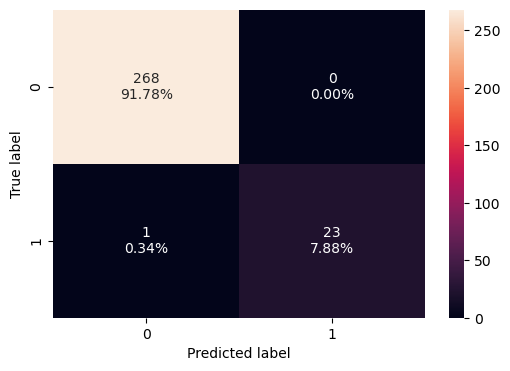

In [72]:
#Fitting the model
decision_tree_2 = DecisionTreeClassifier(max_depth=2)
bagging_classifier_decision_tree_2 = BaggingClassifier(decision_tree_2, random_state=1)
bagging_classifier_decision_tree_2.fit(X_train,y_train)

#Calculating different metrics
bagging_classifier_decision_tree_2_train_perf=model_performance_classification_sklearn(bagging_classifier_decision_tree_2,X_train,y_train)
print(bagging_classifier_decision_tree_2_train_perf)


#Creating confusion matrix
confusion_matrix_sklearn(bagging_classifier_decision_tree_2,X_train,y_train)

   Accuracy    Recall  Precision        F1
0  0.996575  0.958333        1.0  0.978723


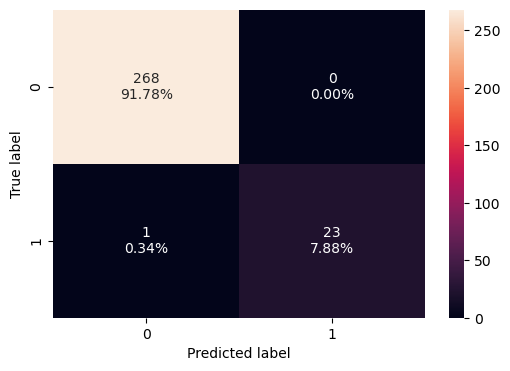

In [73]:
#Fitting the model
decision_tree_3 = DecisionTreeClassifier(max_depth=3)
bagging_classifier_decision_tree_3 = BaggingClassifier(decision_tree_3, random_state=1)
bagging_classifier_decision_tree_3.fit(X_train,y_train)

#Calculating different metrics
bagging_classifier_decision_tree_3_train_perf=model_performance_classification_sklearn(bagging_classifier_decision_tree_3,X_train,y_train)
print(bagging_classifier_decision_tree_3_train_perf)


#Creating confusion matrix
confusion_matrix_sklearn(bagging_classifier_decision_tree_3,X_train,y_train)

   Accuracy    Recall  Precision        F1
0  0.996575  0.958333        1.0  0.978723


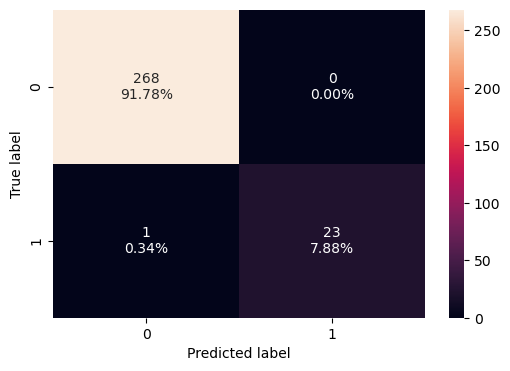

In [74]:
#Fitting the model
decision_tree_4 = DecisionTreeClassifier(max_depth=4)
bagging_classifier_decision_tree_4 = BaggingClassifier(decision_tree_4, random_state=1)
bagging_classifier_decision_tree_4.fit(X_train,y_train)

#Calculating different metrics
bagging_classifier_decision_tree_4_train_perf=model_performance_classification_sklearn(bagging_classifier_decision_tree_4,X_train,y_train)
print(bagging_classifier_decision_tree_4_train_perf)


#Creating confusion matrix
confusion_matrix_sklearn(bagging_classifier_decision_tree_4,X_train,y_train)

   Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


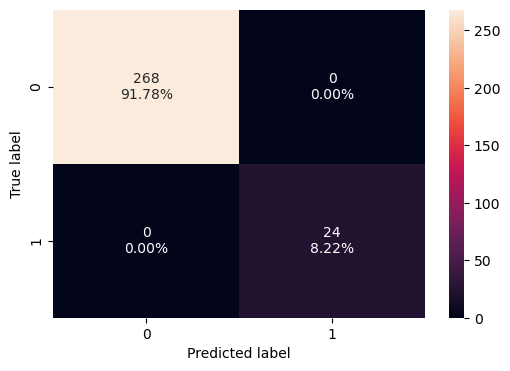

In [75]:
#Fitting the model
decision_tree_5 = DecisionTreeClassifier(max_depth=5)
bagging_classifier_decision_tree_5 = BaggingClassifier(decision_tree_5, random_state=1)
bagging_classifier_decision_tree_5.fit(X_train,y_train)

#Calculating different metrics
bagging_classifier_decision_tree_5_train_perf=model_performance_classification_sklearn(bagging_classifier_decision_tree_5,X_train,y_train)
print(bagging_classifier_decision_tree_5_train_perf)


#Creating confusion matrix
confusion_matrix_sklearn(bagging_classifier_decision_tree_5,X_train,y_train)

   Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


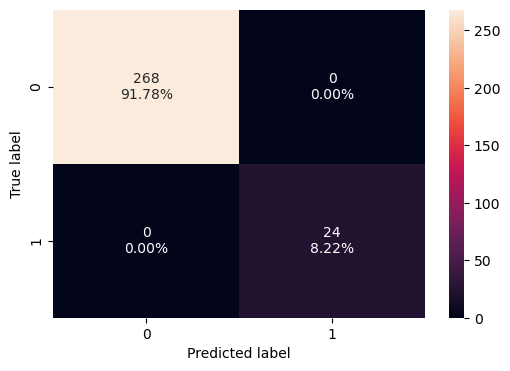

In [79]:
#Fitting the model
ab_classifier = AdaBoostClassifier(random_state=1)
ab_classifier.fit(X_train,y_train)

#Calculating different metrics
ab_classifier_model_train_perf=model_performance_classification_sklearn(ab_classifier,X_train,y_train)
print(ab_classifier_model_train_perf)


#Creating confusion matrix
confusion_matrix_sklearn(ab_classifier,X_train,y_train)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


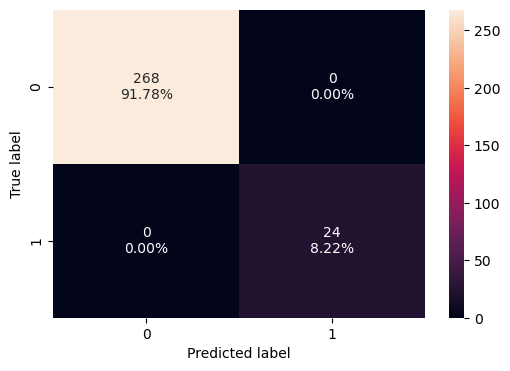

In [80]:
#Fitting the model
gb_classifier = GradientBoostingClassifier(random_state=1)
gb_classifier.fit(X_train,y_train)

#Calculating different metrics
gb_classifier_model_train_perf=model_performance_classification_sklearn(gb_classifier,X_train,y_train)
print("Training performance:\n",gb_classifier_model_train_perf)


#Creating confusion matrix
confusion_matrix_sklearn(gb_classifier,X_train,y_train)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


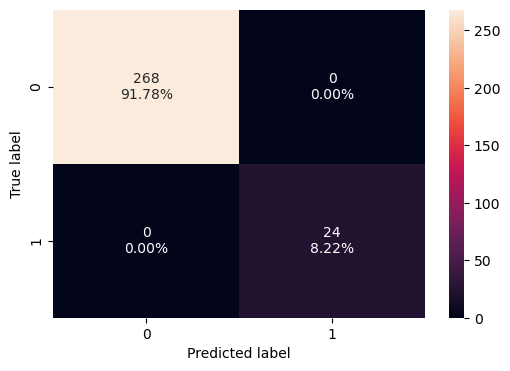

In [82]:
#Fitting the model
xgb_classifier = XGBClassifier(random_state=1, eval_metric='logloss')
xgb_classifier.fit(X_train,y_train)

#Calculating different metrics
xgb_classifier_model_train_perf=model_performance_classification_sklearn(xgb_classifier,X_train,y_train)
print("Training performance:\n",xgb_classifier_model_train_perf)


#Creating confusion matrix
confusion_matrix_sklearn(xgb_classifier,X_train,y_train)

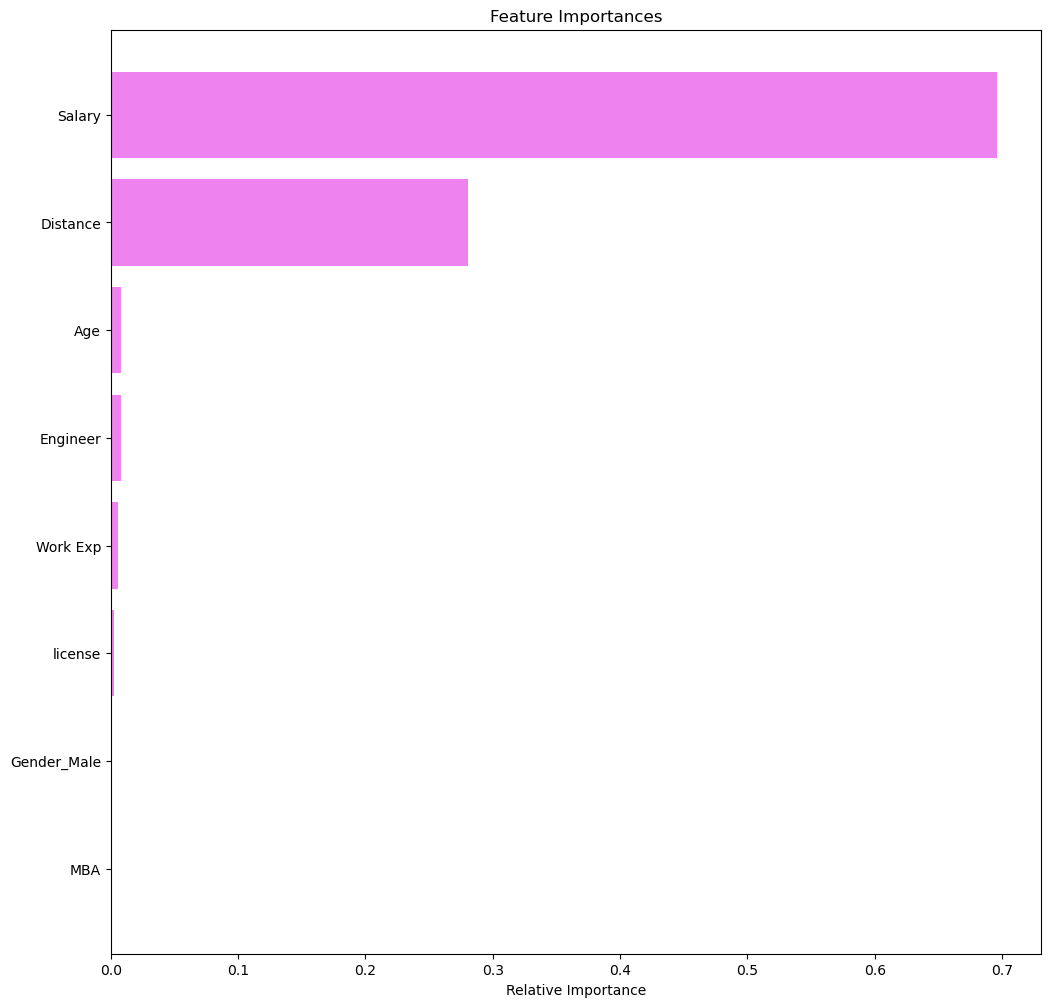

In [83]:
feature_names = X_train.columns
importances = gb_classifier.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Training performance:
    Accuracy  Recall  Precision   F1
0  0.917808     0.0        0.0  0.0


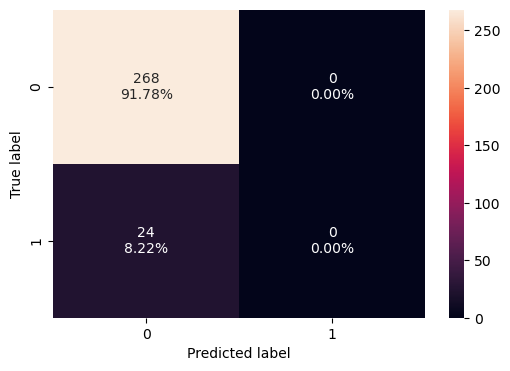

In [84]:
#Fitting the model
Model1 = GradientBoostingClassifier(learning_rate=0.01, n_estimators=50, random_state=1)
Model1.fit(X_train,y_train)

#Calculating different metrics
Model1_train_perf=model_performance_classification_sklearn(Model1,X_train,y_train)
print("Training performance:\n",Model1_train_perf)


#Creating confusion matrix
confusion_matrix_sklearn(Model1,X_train,y_train)

Training performance:
    Accuracy    Recall  Precision        F1
0  0.996575  0.958333        1.0  0.978723


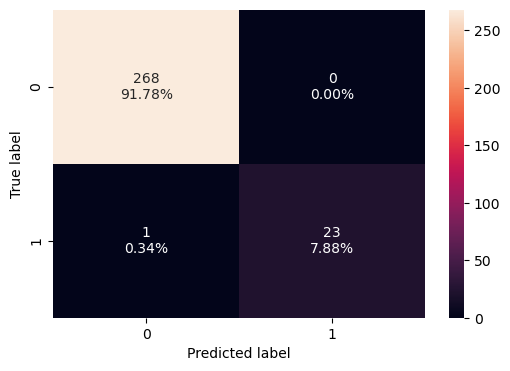

In [85]:
#Fitting the model
Model2 = GradientBoostingClassifier(learning_rate=0.01, n_estimators=100, random_state=1)
Model2.fit(X_train,y_train)

#Calculating different metrics
Model2_train_perf=model_performance_classification_sklearn(Model2,X_train,y_train)
print("Training performance:\n",Model2_train_perf)


#Creating confusion matrix
confusion_matrix_sklearn(Model2,X_train,y_train)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


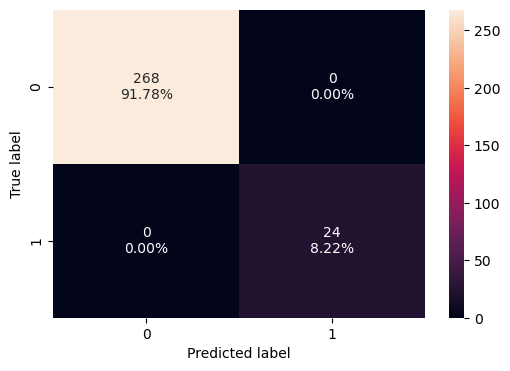

In [86]:
#Fitting the model
Model3 = GradientBoostingClassifier(learning_rate=0.01, n_estimators=400, random_state=1)
Model3.fit(X_train,y_train)

#Calculating different metrics
Model3_train_perf=model_performance_classification_sklearn(Model3,X_train,y_train)
print("Training performance:\n",Model3_train_perf)


#Creating confusion matrix
confusion_matrix_sklearn(Model3,X_train,y_train)

Training performance:
    Accuracy  Recall  Precision        F1
0  0.969178     1.0   0.727273  0.842105


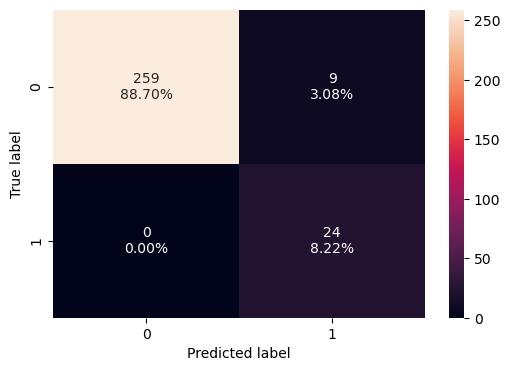

In [87]:
decision_tree_classifier = DecisionTreeClassifier()
bagging_classifier = BaggingClassifier(random_state=1)
random_forest_classifier = RandomForestClassifier(random_state=1)

estimators = [('Bagging Classifier',bagging_classifier), ('Decision Tree Classifier',decision_tree_classifier)]

final_estimator = random_forest_classifier

stacking_classifier= StackingClassifier(estimators=estimators,final_estimator=final_estimator)

stacking_classifier.fit(X_train,y_train)

#Calculating different metrics
stacking_classifier_model_train_perf=model_performance_classification_sklearn(stacking_classifier,X_train,y_train)
print("Training performance:\n",stacking_classifier_model_train_perf)


#Creating confusion matrix
confusion_matrix_sklearn(stacking_classifier,X_train,y_train)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


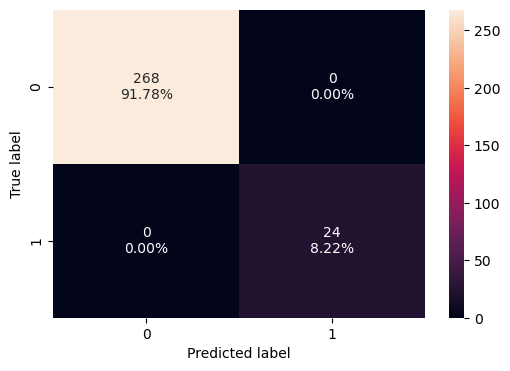

In [88]:
ab_classifier = AdaBoostClassifier(random_state=1)
gb_classifier = GradientBoostingClassifier(random_state=1)
xgb_classifier = XGBClassifier(random_state=1)

estimators = [('Adaboost Classifier',ab_classifier), ('Gradient Boost Classifier',gb_classifier)]

final_estimator = xgb_classifier

stacking_classifier= StackingClassifier(estimators=estimators,final_estimator=final_estimator)

stacking_classifier.fit(X_train,y_train)

#Calculating different metrics
stacking_classifier_model_train_perf=model_performance_classification_sklearn(stacking_classifier,X_train,y_train)
print("Training performance:\n",stacking_classifier_model_train_perf)


#Creating confusion matrix
confusion_matrix_sklearn(stacking_classifier,X_train,y_train)

In [93]:
# Calculating the correlation using pandas' corr() function
correlation = df['Opt_service'].corr(df['Age'])

# Printing the correlation value
print("Correlation:", correlation)

Correlation: 0.6834984162924849


In [94]:
# Calculating the correlation using pandas' corr() function
correlation = df['Opt_service'].corr(df['Work Exp'])

# Printing the correlation value
print("Correlation:", correlation)

Correlation: 0.7315628124546443


In [95]:
# Calculating the correlation using pandas' corr() function
correlation = df['Opt_service'].corr(df['Salary'])

# Printing the correlation value
print("Correlation:", correlation)

Correlation: 0.8107033839223231


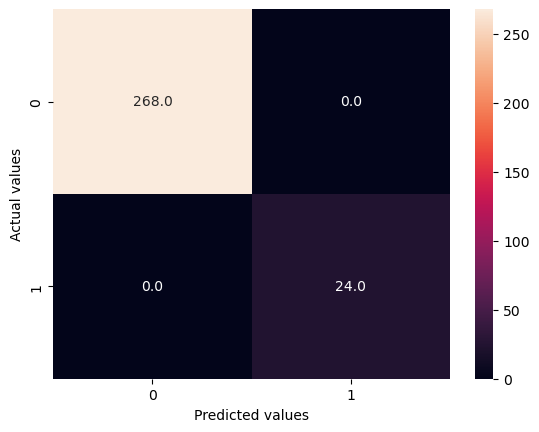

In [96]:
# fitting the baggin classifier on training set
bag = BaggingClassifier(random_state=1)
bag.fit(X_train, y_train)

# predicting on training set
y_train_pred = bag.predict(X_train)

# creating the confusion matrix
sns.heatmap(confusion_matrix(y_train,y_train_pred),annot=True,fmt='.1f')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.show()